In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import KDTree

import sys
sys.path.append('../')

import skeletor as sk

from scipy.signal import convolve

from skeletor.data import loadTestDataset
from skeletor.utils import visualizeRegionAroundPoints

from skeletor.utils import angularHistogramAroundPoint, findDominantHistogramDirections

from pepe.topology import spatialClusterCenters, spatialClusterLabels

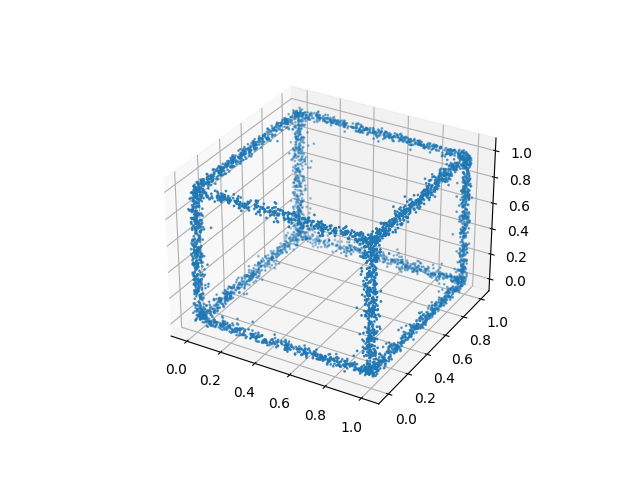

In [18]:
points = loadTestDataset('wireframe_cube_1', extraNoise=.02)

fig = plt.figure()
ax = fig.add_subplot(projection='3d' if points.shape[-1] == 3 else None)

ax.scatter(*points.T, s=1)
plt.show()

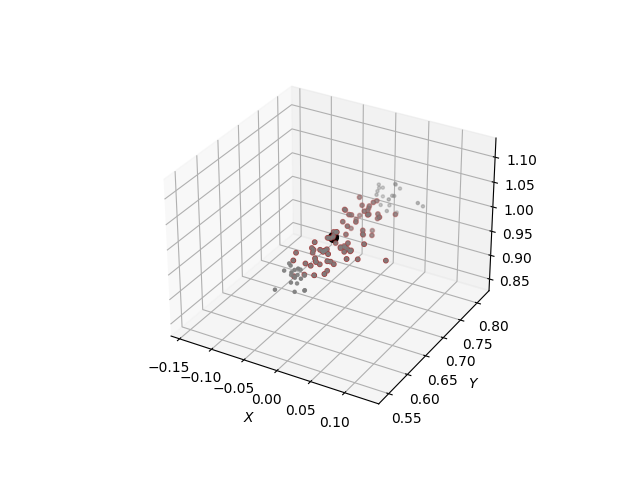

In [19]:
#%matplotlib qt
testPoint = 100
neighborDistance = .1
fig = visualizeRegionAroundPoints(points, testPoint, neighborDistance, neighborDistance*1.5, innerColor='#A02C2C', centerColor='black', s=[5, 10, 50])
ax = fig.gca()

ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

#fig.tight_layout()
plt.show()

In [4]:
def angularHistogramAroundPoint(points, center, adjArr=None, neighborDistance=None, smoothing=5, histBins=50):
    """
    Compute an angular histogram (axes are theta and phi angles) of directions to neighbors
    from the given point.
    
    Parameters
    ----------
    points : numpy.ndarray[N,d]
        Points to be used in determining computing
        the angular histogram, including the point for which
        the histogram is computed around. The central point
        is chosen using the `index` parameter.
        
        If not all points are to be used in creating the histogram,
        whether a given point is to be used or not used can
        be specified by the `adjMat` parameter.
        
    center : numpy.ndarray[d] or int
        The point to use as the center in calculating the angular
        histogram.
        
        If an integer, will be assumed to be the index of the point
        to compute the histogram for in the array `points`.
        
    adjArr : numpy.ndarray[N] or None
        The unweighted adjacency matrix row for the center point, ie.
        adjMat[i,j] == 1 iff the two i and j are neighbors, and 
        0 otherwise. Only points considered to be neighbors will
        be used in calculating the histogram.
        
        If `None`, all points will be considered neighbors.

        There should be very little computational cost to passing
        a larger array of points but then using a adjacency matrix
        to select a subset of those points (essentially just a call
        of `numpy.where`).

    neighborDistance : float or None
        The distance within which two points are considered to
        be neighbors. Only relevant if adjMat is not provided,
        and therefore needs to be calculated.
        
    smoothing : int (odd) or None
        Size of the gaussian smoothing kernel to use on the histogram. 
        
    histBins : int
        Number of bins to use for each axis in generating the histogram.
        
    Returns
    -------
    hist : numpy.ndarray[N,N]
        2D histogram data, with each axis representing a spherical angle.
        
    thetaBins : numpy.ndarray[N]
        Values of theta angle for histogram axis.
    
    phiBins : numpy.ndarray[N]
        Values of phi angle for histogram axis.

    """
    dim = np.shape(points)[-1]

    if not hasattr(center, '__iter__'):
        centerPoint = points[center]
    else:
        centerPoint = center

    # Calculate the adjacency matrix if given a neighbor distance
    if not hasattr(adjArr, '__iter__') and neighborDistance is not None:
        kdTree = KDTree(points)
        indices = kdTree.query_ball_point(centerPoint, r=neighborDistance)
        confirmedAdjArr = np.zeros(len(points))
        confirmedAdjArr[indices] = 1
        
    elif hasattr(adjArr, '__iter__'):
        confirmedAdjArr = adjArr
        
    else:
        confirmedAdjArr = np.ones(len(points))

    # If we have an adjacency array (either directly passed or
    # calculated) choosen a subset of the points as neighbors
    neighbors = np.where(confirmedAdjArr > 0)
    displacements = points[neighbors] - centerPoint
    
    # Compute the average edge orientation for each node
    # Compute the direction of the displacement between each point

    # This is done by calculating the generalized spherical coordinates
    # within which we care only about the angles

    # Convert to spherical coordinates
    sphericalCoords = cartesianToSpherical(displacements)
    radii = sphericalCoords[:,0]
    angleCoords = sphericalCoords[:,1:]

    # For d dimensions, we will have d-1 angles
    # d-2 of them will be bounded between [0, pi], and one
    # will be bounded between [0, 2pi]
    # Here, we will always put the unique one last.
    angleBounds = np.array((([np.pi]*(dim-2)) if dim > 2 else []) + [2*np.pi])
    angleBounds = np.array(list(zip(np.repeat(0, dim-1), angleBounds)))

    # Now generate the d-1 dimensional histogram
    latticeSpacing = angleBounds[:,1]/histBins
    hist = courseGrainField(angleCoords, latticeSpacing=latticeSpacing, fixedBounds=angleBounds, kernelSize=smoothing)
    
    angleAxes = np.array([angleBounds[:,1]*l for l in np.linspace(0, 1, histBins)]).T
    
    return hist, angleAxes


def approxPeakFind(discreteField, smoothing=0.05, threshold=5, periodic=False, debug=False):
    """
    Locate the maxima of a discrete field by finding clusters of points
    with a value greather than a threshold.

    Parameters
    ----------
    discreteField : numpy.ndarray[i,j,k,...]
        d-dimensional scalar field to perform peak finding on.

    smoothing : float
        Smoothing parameter that determines the size of the
        smoothing kernel applied to the discrete field.

        Calculates the kernel size as the diagonal length of the
        field times this parameter.

    threshold : float
        Factor to multiply the mean of the nonzero values in the
        discrete field by to determine which points could comprise a
        maximum.

    periodic : bool
        Whether the discrete field wraps around to itself at the edges.

    debug : bool
        Whether to plot debug information about the peak finding.

    Returns
    -------
    peaks : numpy.ndarray[N,d]
        Indices for each axis of the N detected peaks.
    """
    dim = len(np.shape(discreteField))

    smoothingKernel = int(np.sqrt(np.sum(np.array(np.shape(discreteField))**2))*smoothing)
    # Make sure it is odd
    smoothingKernel += (smoothingKernel+1) % 2
    
    # Use a gaussian profile (normalization is chosen as `smoothingKernel`
    # arbitrarily)
    kernelProfile = np.exp(-np.arange(-(smoothingKernel-1)//2, (smoothingKernel-1)//2+1)**2 / smoothingKernel)

    kernel = np.multiply.outer(*[kernelProfile for _ in range(dim)])

    # If our field is periodic, we need to pad each side with the opposing
    # side.
    if periodic:
        padding = (smoothingKernel+1)//2
        paddedField = np.pad(discreteField, padding, mode='wrap')
        smoothedField = convolve(paddedField, kernel, mode='same')
        
        # Cut out the padding
        for i in range(dim):
            smoothedField = np.take(smoothedField, np.arange(padding, np.shape(paddedField)[i] - padding + 1), axis=i)
        
    else:
        smoothedField = convolve(discreteField, kernel, mode='same')

    # Now take points above the average multiplied by some factor
    #smoothedField[smoothedField == 0] = np.nan
    includePoints = np.array(np.where(smoothedField > np.nanmean(smoothedField)*threshold)).T

    # Cluster them together
    #centers, weights = spatialClusterCenters(includePoints, l=.1, wrapPoints=np.shape(smoothedField) if periodic else None, return_weights=True)
    # Renormalize weights
    #weights = weights / np.sum(weights)
    labels = spatialClusterLabels(includePoints, l=.15, wrapPoints=np.shape(smoothedField) if periodic else None)
    centers = np.zeros((int(np.max(labels)+1), dim))

    for i in range(len(centers)):
        centers[i] = includePoints[labels == i][np.argmax([smoothedField[tuple(ind)] for ind in includePoints[labels == i]])]
        
    # Sort by weight
    #order = np.argsort(weights)
    #centers = centers[order]
    #weights = weights[order]
    
    if debug:
        if dim == 2:
            # Cluster them together
            #labels = spatialClusterLabels(includePoints, l=.1, wrapPoints=np.shape(smoothedField) if periodic else None)
        
            plt.imshow(smoothedField)
            for i in range(int(np.max(labels)+1)):
                plt.scatter(*includePoints[np.where(labels == i)].T[::-1], alpha=.3)
            plt.scatter(*centers.T[::-1], c='tab:red')
            plt.show()

    return centers

def findDominantHistogramDirections(hist, angleAxes, debug=False):
    r"""
    Based on the angular histogram (see `angularHistogramAroundPoint()`),
    compute the dominant directions, or the directions pointing towards
    neighbors.
    
    Parameters
    ----------
    hist : numpy.ndarray[N,N]
        d-1 dimensional histogram data, with each axis representing
        a spherical angle.
        
    angleAxes : list of numpy.ndarray[N]
        Values of the spherical angles for histogram axes. The
        unique axis (that has a range [0, 2pi]) should be last.
    
    debug : bool
        Whether to plot the peak finding data (`True`) or not (`False`).
        
    Returns
    -------
    peakDirections : numpy.ndarray[P,d]
        Unit vectors in the dominant directions in cartesian
        coordinates.
    """
    # Find peaks in the histogram
    # Peak prevalence is the range the peak spans; eg. a peak
    # that spans from the minimum to the maximum of the data has
    # a prevalence of 1
    peaks = approxPeakFind(hist, periodic=True, debug=debug)

    # Convert from indices to angles
    peakAngles = np.zeros((len(peaks), len(angleAxes)))
    for i in range(len(angleAxes)):
        peakAngles[:,i] = angleAxes[i][np.round(peaks[:,i]).astype(np.int64)]

    # Convert from spherical to cartesian
    # Use 1 as the radius since we want unit vectors
    peakSphericalCoords = np.array([[1, *p] for p in peakAngles])    
    
    return sphericalToCartesian(peakSphericalCoords)

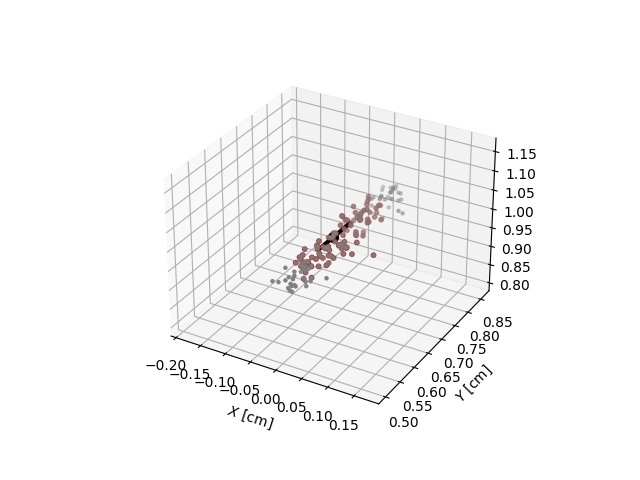

In [21]:
# Look around a specific point

for i in range(10):
    plt.close()
%matplotlib widget

testPoint = 100
neighborDistance = .13

hist, axes = angularHistogramAroundPoint(points, testPoint, neighborDistance=neighborDistance)
peakDirections = findDominantHistogramDirections(hist, axes, 0.5)

# plt.pcolor(axes[0], axes[1], hist)
# plt.colorbar()
# plt.show()

fig = visualizeRegionAroundPoints(points, testPoint, neighborDistance, neighborDistance*1.5, innerColor='#A02C2C', centerColor='black', s=[5, 10, 50])
ax = fig.gca()

for i in range(len(peakDirections)):
    linePoints = np.array([points[testPoint], points[testPoint] + .05*peakDirections[i]])
    ax.plot(*linePoints.T, linewidth=3, c='black')

ax.set_xlabel('$X$ [cm]')
ax.set_ylabel('$Y$ [cm]')
#ax.set_zlabel('$Z$ [cm]')

#fig.tight_layout()
plt.show()

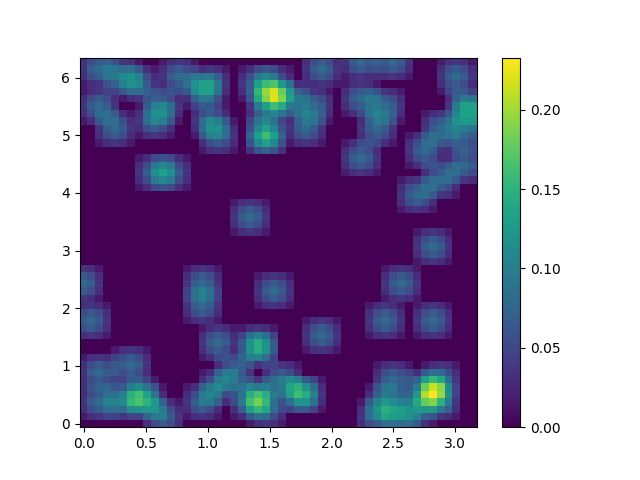

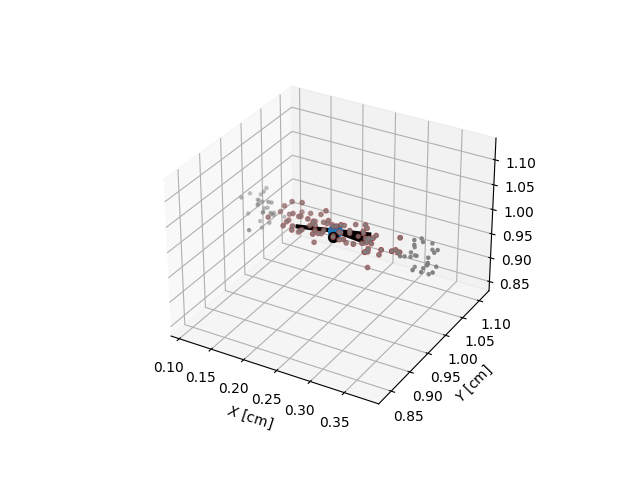

In [28]:
# Look around the CoM near a specific point

for i in range(10):
    plt.close()
%matplotlib widget

testPoint = 101
neighborDistance = .1

kdTree = KDTree(points)
neighbors = kdTree.query_ball_point(points[testPoint], neighborDistance)
adjArr = np.zeros(len(points))
adjArr[neighbors] = 1

center = np.mean(points[neighbors], axis=0)

hist, axes = angularHistogramAroundPoint(points, center, adjArr=adjArr)
peakDirections = findDominantHistogramDirections(hist, axes, .7)

plt.pcolor(axes[0], axes[1], hist)
plt.colorbar()
plt.show()

fig = visualizeRegionAroundPoints(points, testPoint, neighborDistance, neighborDistance*1.5, innerColor='#A02C2C', centerColor='black', s=[5, 10, 50])
ax = fig.gca()

for i in range(len(peakDirections)):
    linePoints = np.array([center, center + .05*peakDirections[i]])
    ax.plot(*linePoints.T, linewidth=3, c='black')
ax.scatter(*center[None,:].T, s=100)

ax.set_xlabel('$X$ [cm]')
ax.set_ylabel('$Y$ [cm]')
#ax.set_zlabel('$Z$ [cm]')

#fig.tight_layout()
plt.show()